In [40]:
from dotenv import load_dotenv

load_dotenv()

True

In [41]:
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from typing_extensions import List, Dict, TypedDict, Annotated
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph
import pandas as pd
from pydantic import Field, BaseModel
from pydantic.types import StringConstraints

In [42]:
class State(TypedDict):
    data: List[Dict]
    product_name: str
    product_description: str
    category: str
    
class KeywordDistribute(State):
    title_keyword: List[str] = Field(..., description='Title에 들어갈 키워드들')
    bp_keyword: List[str] = Field(..., description='Bullet Point에 들어갈 키워드들')
    description_keyword: List[str] = Field(..., description='Description에 들어갈 키워드들')
    leftover: List[str] = Field(..., description='사용되지 않은 키워드들')
    
class TitleState(KeywordDistribute):
    title: str

class BPState(KeywordDistribute):
    bp: List[str]

class DescriptionState(KeywordDistribute):
    description: str

class TitleOutput(BaseModel):
    title: Annotated[
        str,
        StringConstraints(min_length=1, max_length=200),
        Field(description="최대 200자까지 허용")
    ]
class BPOutput(BaseModel):
    bp: Annotated[
        List[
            Annotated[
                str, 
                StringConstraints(min_length=1, max_length=250)
            ]
        ],
        Field(..., description="각 항목 최대 250자")
    ]
    
class DescriptionOutput(BaseModel):    
    description: Annotated[
        str,
        StringConstraints(min_length=1, max_length=2000),
        Field(description="최대 2000자까지 허용")
    ]

In [43]:
llm = ChatOpenAI(model='gpt-4o', temperature=0)

In [44]:
raw_keywords = pd.read_csv('./processed_keywords.csv')[['Keywords', 'Linkage_Class']]
keywords = raw_keywords.to_dict(orient='records')

In [45]:
keyword_template = '''
다음은 아마존에 판매할 상품 {product_name}에 관한 다양한 키워드들과, 키워드가 얼마나 실제 상품과 연관되었는지(Linkage_Class)를 보여주는 데이터입니다.

Linkage_Class의 의미는 다음과 같습니다.
Direct: 
- 키워드에 제품 핵심 기능/명칭이 그대로 포함됨
Intermediate: 
- 제품군(카테고리) 단어와 유사성 있음 (Kitchen gadget, Meat grinder, Food prep)
- 직접적으로는 아니지만 **카테고리/사용 맥락**에서 가까움
Indirect:
- 상호보완/시즌/니치/롱테일 키워드
- 기능은 다르지만 같은 고객층에게 매력적인 보완 제품 키워드


상품 판매 페이지에 이 키워드들을 사용할 예정인데, Title/Bullet Point/Description/Leftover에 이 키워드들을 기준에 맞게 분배해주세요.
- Title: 핵심적이고, key attribute가 들어감
- Bullet Point: 고객 입장에서의 상품의 효능이 들어감
- Description: 상품에 대한 설명
- Leftover: 위의 항목에 사용되지 않은 키워드

---
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
키워드 데이터:
{keyword}
---
[출력]
'''

keyword_prompt = PromptTemplate.from_template(keyword_template)

In [46]:
def keyword_distribute(state: State):
    prompt = keyword_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'keyword': state['data'],
        }
    )
    structured_llm = llm.with_structured_output(KeywordDistribute)
    res = structured_llm.invoke(prompt)
    return {'title_keyword': res['title_keyword'], 'bp_keyword': res['bp_keyword'], 'description_keyword': res['description_keyword'], 'leftover': res['leftover']}    

In [47]:
title_examples = [
    {
        "title_keyword": "chicken, chicken shredder, tools, chicken shredder tool twist, meat shredder, shredder, pork, tool, hand tools, meat shredder tool twist, chicken shredder tool twist large, shredder kitchen, chicken shredder tool, food shredder, chicken breast, kitchen, food, meat, shredded chicken, cooked chicken, kitchen gadgets, meal prep, kitchen tools, amazon kitchen, cooking gifts, cooking gadgets",
        "title": "Chicken Shredder, 10'' Large Chicken Shredder Tool Twist with Transparent Lid, Ergonomic Handle and Anti-Slip Base, Dishwasher Safe, Ideal for Meal Prep"
    }
]

title_example_prompt = PromptTemplate.from_template('[keyword]\n{title_keyword}\n[output]\nTitle: {title}')

title_prefix = """
예시는 참고용으로 사용하고, 다음 정보를 확인해서 아마존 상품의 타이틀을 작성해 주세요.
목표는 검색 노출을 극대화 하는 것으로, 반드시 아래 규칙을 지켜주세요

[규칙]
- Title must not exceed 200 characters.
- Include the brand name, product line, and key attributes.
- Use relevant keywords in the first 80 characters.
- Capitalize the first letter of every word except prepositions, conjunctions, and articles.
"""

title_snuffix = """
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
{title_keyword}
---
[출력]
최종 타이틀:  
"""

title_prompt = FewShotPromptTemplate(
    examples=title_examples,
    example_prompt=title_example_prompt,
    prefix=title_prefix,
    suffix=title_snuffix,
    input_variables=["product_name", "category", "product_description", "title_keyword"],
)

In [ ]:
def generate_title(state: TitleState):
    prompt = title_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'title_keyword': state['title_keyword'],
        }
    )
    structured_llm = llm.with_structured_output(TitleOutput)
    res = structured_llm.invoke(prompt)
    return {'title': res['title']}

In [49]:

bp_examples = [
    {
        "bp_keyword": "chicken, chicken shredder, tools, chicken shredder tool twist, meat shredder, shredder, pork, tool, hand tools, meat shredder tool twist, chicken shredder tool twist large, shredder kitchen, chicken shredder tool, food shredder, chicken breast, kitchen, food, meat, shredded chicken, cooked chicken, kitchen gadgets, meal prep, kitchen tools, amazon kitchen, cooking gifts, cooking gadgets",
        "bp": [
            'EASY SHREDDING: Effortlessly shred cooked chicken, pork, or beef into even pieces, perfect for tacos, salads, sandwiches, and more. Save time and elevate meal prep with this essential kitchen tool.',
            'STABLE ANTI-SLIP BASE: Equipped with a non-slip base for stability, ensuring safe and efficient shredding without the tool slipping during use.'
            'LARGE CAPACITY WITH TRANSPARENT LID: The 10-inch size accommodates family-sized portions. The transparent lid lets you monitor the shredding process, ensuring perfect results every time.',
            'ERGONOMIC HANDLE DESIGN: Designed with a comfortable, easy-grip handle to reduce hand strain and improve control, making shredding tasks quick and effortless.',
            'DISHWASHER SAFE: Made for convenience, the shredder is dishwasher-safe and easy to clean, ensuring a hassle-free experience in busy kitchens.',
        ]
    }
]

bp_example_prompt = PromptTemplate.from_template('[keyword]\n{bp_keyword}\n[output]\nBullet Point: {bp}')

bp_prefix = """
예시는 참고용으로 사용하고, 다음 정보를 확인해서 아마존 상품의 Bullet Point를 작성해 주세요.
목표는 고객에게 정확한 정보를 전하고, 고객이 사용하고 싶게 만드는 것으로, 반드시 아래 규칙을 지켜주세요

[규칙]
- Each bullet points must not exceed 250 characters.
- Write readable bullet points that explain how the product can benefit customers. 
- Key Features write the product's main functions and characteristics as a short list of sentences within 100 characters maximum, capitalizing the first letter of each item.

1. 각 BP의 길이는 250자를 넘어가면 안됩니다.
2. 첫 3개의 BP는 상품의 효능에 관련된 설명으로, 고객 입장에서 상품의 가치를 판단할 수 있는 키워드를 사용합니다.
3. 나머지 2개의 BP는 상품의 기능에 관련된 설명으로, 상품이 할 수 있는 기능에 관한 키워드를 사용합니다.
4. 더 제시할 키워드가 없다면, 생성해서 채우지 말고 그 시점에서 답변을 반환하세요
5. 키워드를 나열하는 식이 아닌, 문장형으로 작성하세요.
"""

bp_snuffix = """
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
{bp_keyword}
---
[출력]
최종 BP:  
"""

bp_prompt = FewShotPromptTemplate(
    examples=bp_examples,
    example_prompt=bp_example_prompt,
    prefix=bp_prefix,
    suffix=bp_snuffix,
    input_variables=["product_name", "category", "product_description", "bp_keyword"],
)

In [50]:
def generate_bp(state: BPState):
    prompt = bp_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'bp_keyword': state['bp_keyword'],
        }
    )
    structured_llm = llm.with_structured_output(BPOutput)
    res = structured_llm.invoke(prompt)
    return {'bp': res['bp']}

In [51]:
description_examples = [
    {
        "description_keyword": "chicken, chicken shredder, tools, chicken shredder tool twist, meat shredder, shredder, pork, tool, hand tools, meat shredder tool twist, chicken shredder tool twist large, shredder kitchen, chicken shredder tool, food shredder, chicken breast, kitchen, food, meat, shredded chicken, cooked chicken, kitchen gadgets, meal prep, kitchen tools, amazon kitchen, cooking gifts, cooking gadgets",
        "description": '''
[Why You'll Love It]
 
  The 10'' Chicken Shredder Tool Twist is your ultimate kitchen companion for quick, safe, and efficient meal preparation. Whether you're making shredded chicken tacos, salads, or pulled pork sandwiches, this tool saves time and effort, delivering professional results in seconds.
 
  [Key Features]
 
  • Effortless Shredding: Quickly and evenly shred cooked chicken, pork, or beef for various dishes.
 
  • Non-Slip Stability: The anti-slip base ensures safety and ease during use.
 
  • Large Capacity: Perfect for family-sized meals with a 10-inch bowl and a transparent lid to monitor the process.
 
  • Ergonomic Design: Comfortable handle reduces hand strain and ensures optimal control.
 
  • Easy Maintenance: Dishwasher-safe design makes cleaning a breeze.
 
  [Perfect for These People]
 
  Crafted with durability in mind, this versatile shredder is ideal for home cooks, meal prep enthusiasts, BBQ lovers, and even pet owners needing a quick way to prepare shredded meat. Add this must-have gadget to your kitchen and transform your cooking experience.
        
        '''
    }
]

description_example_prompt = PromptTemplate.from_template('[keyword]\n{description_keyword}\n[output]\nDescription: {description}')

description_prefix = """
예시를 참고하고, 다음 정보를 확인해서 아마존 상품의 Description를 작성해 주세요.
목표는 고객에게 정확한 정보를 깔끔하게 전달하는 것으로, 반드시 아래 규칙을 지켜주세요

[규칙]
1. Description의 최대 길이는 2000자입니다.
2. 첫 200자 안에 최대한 의미있는 내용을 중요한 키워드를 포함해 한 문장으로 작성하세요.
3. 나머지 내용은 고객이 읽기 편하게 키워드를 활용해서 작성하세요.
4. 더 제시할 키워드가 없다면, 생성해서 채우지 말고 그 시점에서 답변을 반환하세요
5. answer must be written in english
"""

description_snuffix = """
[데이터]
상품명: {product_name}
카테고리: {category}
상품 설명: {product_description}
---
[키워드]
{description_keyword}
---
[출력]
최종 Description:  
"""

description_prompt = FewShotPromptTemplate(
    examples=description_examples,
    example_prompt=description_example_prompt,
    prefix=description_prefix,
    suffix=description_snuffix,
    input_variables=["product_name", "category", "product_description", "description_keyword"],
)

In [52]:
def generate_description(state: DescriptionState):
    prompt = description_prompt.invoke(
        {
            'product_name': state['product_name'], 
            'category': state['category'],
            'product_description': state['product_description'], 
            'description_keyword': state['description_keyword'],
        }
    )
    structured_llm = llm.with_structured_output(DescriptionOutput)
    res = structured_llm.invoke(prompt)
    return {'description': res['description']}

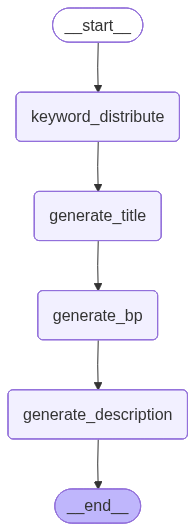

In [53]:
# 단순히 1열로 노드들이 진행되는 경우 만드는게 매우 간단함
builder = StateGraph(State).add_sequence(
    [keyword_distribute, generate_title, generate_bp, generate_description]
)

builder.add_edge(START, 'keyword_distribute')

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
final_state = graph.invoke({
    'product_name': 'Chicken Shredder',
    'category': 'Kitchen Gadgets',
    'product_description': 'it is a tool to rip chicken breasts. easy to use, and easy to dishwash',
    'data': keywords,
})

from pprint import pprint
pprint(final_state)

TypeError: 'TitleOutput' object is not subscriptable